# Use NLI model on Autogestion dataset

In [ ]:
%load_ext autoreload
%autoreload 2

from IPython.display import display, HTML
import sys
import os
from os import path

sys.path.append("./../src")
tmp_path = path.join('.cache', '2023-04-04')
os.makedirs(tmp_path,exist_ok=True)

In [ ]:
#SERVER_DIR = '/Users/dunguyen/Projects/IGRIDA/RUNS'
SERVER_DIR = '/srv/tempdd/dunguyen/RUNS'
LOG_PATH = path.join(SERVER_DIR, 'logs')
DATA_CACHE = path.join(SERVER_DIR, 'dataset')
MODEL_CACHE = path.join(SERVER_DIR, 'models')

MONGO_CACHE = path.join(DATA_CACHE, 'archival', 'mongo_db') # Generated from Mongodb
AUTOGESTION_CACHE = path.join(DATA_CACHE, 'archival', 'autogestion') # generated from autogestion repository
INFERENCE_CACHE = path.join(DATA_CACHE, 'archival', 'inference') # model generation

In [ ]:
from modules.logger import init_logging
from modules.logger import log

init_logging(color=True)

In [ ]:
# CHECK GPU hardware

!nvidia-smi

# Evaluation in generated test set

## Model's predictions

Load model

In [ ]:
from data_module.archival_module import ArchivalNLIDM
from model_module.lstm.archival_lstm_module import ArchivalLstmModule
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

###############
# PREPARE DATA
###############
dm = ArchivalNLIDM(cache_path=DATA_CACHE, batch_size=16, num_workers=8, version='v3')
dm.prepare_data()
dm.setup('test')

###############
# MODEL MODULE
###############

# model's parameters (could be changed in other versions)
MODEL_NAME = 'v3/run=0_vector=0_lentropy=0'
m_kwargs = dict(
    n_context=1, 
    d_embedding=300
)

# leave the default ones
model = ArchivalLstmModule(cache_path=MODEL_CACHE,
    mode='dev',
    vocab=dm.vocab,
    concat_context=True,
    data='archival',
    num_class=dm.num_class, **m_kwargs)

ckpt_path = path.join(LOG_PATH, 'archival', MODEL_NAME, 'checkpoints', 'best.ckpt')
if torch.cuda.is_available():
    checkpoint = torch.load(ckpt_path)
else:
    checkpoint = torch.load(ckpt_path, map_location=torch.device('cpu'))
    
model.to(device)
model.load_state_dict(checkpoint['state_dict'])
model.eval()

print('Model is in cuda: ',next(model.parameters()).is_cuda)

Check accuracy

In [6]:
import torchmetrics as m

accuracy = m.Accuracy().to(device)

all_y_true = list()
all_y_hat = list()

for batch in dm.test_dataloader():
    y_true = batch['y_true'].to(device)
    with torch.no_grad():
        y_hat, a_hat = model(premise_ids=batch['premise_ids'].to(device), 
            hypothesis_ids=batch['hypothesis_ids'].to(device), 
            premise_padding=batch['padding_mask']['premise'].to(device),
            hypothesis_padding=batch['padding_mask']['hypothesis'].to(device))
        
    y_hat = y_hat.softmax(-1)    
    y_hat = y_hat[:, 1]
    
    accuracy.update(y_hat, y_true)
    
    all_y_true.append(y_true)
    all_y_hat.append(y_hat)   
    
all_y_hat = torch.cat(all_y_hat)
all_y_true = torch.cat(all_y_true)

accuracy.compute()

tensor(0.6122, device='cuda:0')

Precision / Recall curve 

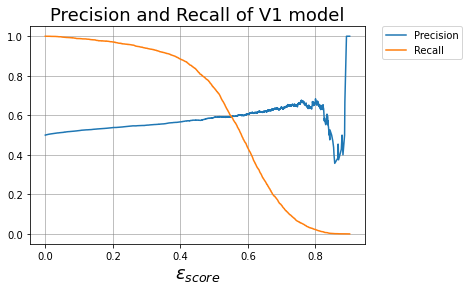

In [7]:
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot as plt


precision, recall, thresholds = precision_recall_curve(all_y_true.cpu(), all_y_hat.cpu())
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("$\epsilon_{score}$",fontsize=18)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(visible=True, which="both", axis="both", color='gray', linestyle='-', linewidth=0.5)
plt.title('Precision and Recall of V1 model', fontsize=18)
plt.show()

Distribution

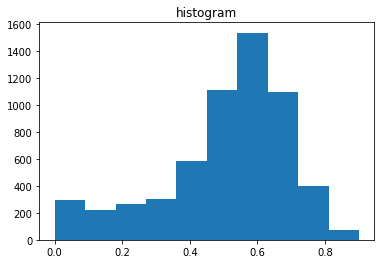

In [37]:
y_score = all_y_hat.cpu().numpy()

plt.hist(y_score) 
plt.title("histogram") 
plt.show()

## Model's attention map

### Backup plan: make inference on the fly

In [10]:
import pandas as pd

df_inference = pd.DataFrame()

for batch in dm.test_dataloader():
    y_true = batch['y_true'].to(device)
    padding_mask = batch['padding_mask']
    B = len(y_true)
    
    with torch.no_grad():
        y_hat, a_hat = model(premise_ids=batch['premise_ids'].to(device), 
            hypothesis_ids=batch['hypothesis_ids'].to(device), 
            premise_padding=batch['padding_mask']['premise'].to(device),
            hypothesis_padding=batch['padding_mask']['hypothesis'].to(device))
        
    y_hat = y_hat.softmax(-1)    
    y_hat = y_hat[:, 1]
    
    a_hat = {side: a_hat[side].softmax(-1) for side in a_hat}
    a_hat = { side : [ attention[i][~padding_mask[side][i]].tolist()  for i in range(B) ] for side, attention in a_hat.items() }

    inferench_batch = {}
    for side in ['premise', 'hypothesis']:
        COLUMNS = [side + '.norm', side + '.form']
        inferench_batch.update({c : batch[c] for c in COLUMNS})
        inferench_batch.update({side + '.attention' : a_hat[side]})



    inferench_batch['y_true'] = batch['y_true'].tolist()
    inferench_batch['y_score'] = y_hat.tolist()
    
    inferench_batch = pd.DataFrame(inferench_batch)
    
    df_inference = pd.concat([df_inference, inferench_batch])
    
df_inference.reset_index(drop=True, inplace=True)

In [11]:
EPSILON_Y_HAT = 0.8

df_inference['y_hat'] = df_inference['y_score'] > EPSILON_Y_HAT

df_true_positive = df_inference[df_inference['y_hat'] & df_inference['y_true']]
df_true_positive = df_true_positive.sort_values(by=['y_score'], ascending=False)
df_true_positive.reset_index(drop=True, inplace=True)

print('% True positive:', len(df_true_positive) / len(df_inference))
print('# True positive:', len(df_true_positive))

% True positive: 0.01141008174386921
# True positive: 67


In [12]:
from modules import highlight
BEGIN = 0
END = 10    

html='<table>'
html += '<thead><tr><th>Index</th> <th>Premise</th> <th>Hypothesis</th> <th>Score</th> </tr></thead>'

for idx, row in df_true_positive[BEGIN:END].iterrows():
    
    idx = str(row.name)
    #premise = [tk['form'] for tk in s_tokens]
    premise = highlight(row['premise.form'], row['premise.attention'])

    #hypothesis = ' '.join([tk['form'] for tk in t_tokens])
    hypothesis = highlight(row['hypothesis.form'], row['hypothesis.attention'])

    score = str(round(row['y_score'], 2))
    
    html += '<tr>' + '<td>' + idx + '</td>' + '<td>' +premise + '</td>' + '<td>' + hypothesis + '</td>' + '<td>' + score + '</td>' +'</tr>'
    
html += '</table>'
display(HTML(html))

Most highlighted words in `mass` (%) of attention mass ?

In [13]:
from modules.utils import binarize_attention
from collections import Counter
from spacy.lang.fr.stop_words import STOP_WORDS
from string import punctuation

attended_word_frequency = {'premise' : Counter(), 'hypothesis' : Counter() }
df_frequency = dict()

# Count words
for side in ['premise', 'hypothesis']:
    
    for idx, row in df_true_positive.iterrows():
    
        alpha = torch.tensor(row[side+'.attention'])

        # binarize on alpha
        alpha = binarize_attention(alpha)

        words = [w for w, a in zip(row[side+'.norm'], alpha) if a > 0]

        attended_word_frequency[side].update(words)
        
    # Sort by most frequent to the top, transform into dictionary
    attended_word_frequency[side] = { w: f for w, f in attended_word_frequency[side].most_common()}
    
    df_frequency[side] = pd.DataFrame([attended_word_frequency[side]], index=['Count']).transpose()
    
    print('20 most attended words in',side)
    display(df_frequency[side][:20].transpose())

20 most attended words in premise


,.,le,un,de,être,en,avoir,ne,dans,pas,que,qui,se,«,travailleur,à,pouvoir,autogestion,fourier,même
Count,67,50,45,31,22,15,13,12,11,10,10,10,9,9,8,8,7,6,5,4


20 most attended words in hypothesis


,.,le,être,un,il,à,se,de,avoir,",",ce,que,qui,(,dans,pouvoir,plus,en,au,n'
Count,63,61,30,29,26,25,20,20,18,18,17,13,13,11,11,11,11,10,10,9


In [14]:
from string import punctuation
from spacy.lang.fr.stop_words import STOP_WORDS
from spacy.lang.fr.punctuation import TOKENIZER_PREFIXES, TOKENIZER_INFIXES, TOKENIZER_SUFFIXES

INGORE = set().union(STOP_WORDS, set(punctuation), set(TOKENIZER_PREFIXES), set(TOKENIZER_INFIXES), set(TOKENIZER_SUFFIXES))

for side, frequency in attended_word_frequency.items():
    attended_word_frequency[side] = {k: f for k, f in frequency.items() if k not in INGORE}
    df_frequency[side] = pd.DataFrame([attended_word_frequency[side]], index=['Count']).transpose()
    print('20 most attended words without stop words in',side)
    display(df_frequency[side][:20].transpose())

20 most attended words without stop words in premise


,travailleur,pouvoir,autogestion,fourier,force,ouvrier,rapport,social,entreprise,communiste,critique,classe,organisation,complexe,élément,industriel,capital,idée,parti,participation
Count,8,7,6,5,4,4,4,3,3,3,3,3,3,2,2,2,2,2,2,2


20 most attended words without stop words in hypothesis


,pouvoir,ouvrier,travailleur,économique,faire,exemple,contrôle,majorité,voir,mettre,ordre,entreprise,difficulté,mécanicien,usine,révolutionnaire,capital,moment,coopérative,monde
Count,11,7,5,5,5,4,4,4,3,3,3,3,3,3,3,3,3,3,2,2


Ignoring the stop-words, what are the most highlighted words ?

In [15]:
from string import punctuation
from spacy.lang.fr.stop_words import STOP_WORDS
from spacy.lang.fr.punctuation import TOKENIZER_PREFIXES, TOKENIZER_INFIXES, TOKENIZER_SUFFIXES

IGNORE = set().union(STOP_WORDS, set(punctuation), set(TOKENIZER_PREFIXES), set(TOKENIZER_INFIXES), set(TOKENIZER_SUFFIXES))

for side, frequency in attended_word_frequency.items():
    attended_word_frequency[side] = {k: f for k, f in frequency.items() if k not in IGNORE}
    df_frequency[side] = pd.DataFrame([attended_word_frequency[side]], index=['Count']).transpose()
    print('20 most attended words without stop words in',side)
    display(df_frequency[side][:20].transpose())

20 most attended words without stop words in premise


,travailleur,pouvoir,autogestion,fourier,force,ouvrier,rapport,social,entreprise,communiste,critique,classe,organisation,complexe,élément,industriel,capital,idée,parti,participation
Count,8,7,6,5,4,4,4,3,3,3,3,3,3,2,2,2,2,2,2,2


20 most attended words without stop words in hypothesis


,pouvoir,ouvrier,travailleur,économique,faire,exemple,contrôle,majorité,voir,mettre,ordre,entreprise,difficulté,mécanicien,usine,révolutionnaire,capital,moment,coopérative,monde
Count,11,7,5,5,5,4,4,4,3,3,3,3,3,3,3,3,3,3,2,2


Words received most of attention weight

In [18]:
import numpy as np
import json

ATTENDED_TOKEN_PATH = path.join(LOG_PATH, 'archival', MODEL_NAME, 'predictions', 'words_attention_mass.json')

if path.exists(ATTENDED_TOKEN_PATH):
    
    # Load the attention mass if the file exits
    with open(ATTENDED_TOKEN_PATH, 'r') as f:
        avg_attention_mass = json.load(f)
else:

    # flatten and align tokens and attentions
    tokens = np.concatenate(df_true_positive['premise.norm'].tolist()).tolist()
    attentions = np.concatenbate(df_true_positive['premise.attention'].tolist()).tolist()
    assert len(tokens) == len(attentions), 'Not compatible length'

    # cumulate attention weights
    attention_mass = {}
    word_occurence = {}
    for w, a in zip(tokens, attentions):
        # w : word
        # a : attention weight
        attention_mass[w] = attention_mass.get(w, 0) + a
        word_occurence[w] = word_occurence.get(w, 0) + 1

    # renormalized by the word frequency 
    avg_attention_mass = {w : attention_mass[w]/word_occurence[w] for w in attention_mass}
        
    # sort by descending order
    avg_attention_mass = {k: v for k, v in sorted(avg_attention_mass.items(), key=lambda item: -item[1])}

    # Save to file
    with open(ATTENDED_TOKEN_PATH, 'w') as f:
        json.dump(avg_attention_mass, f)

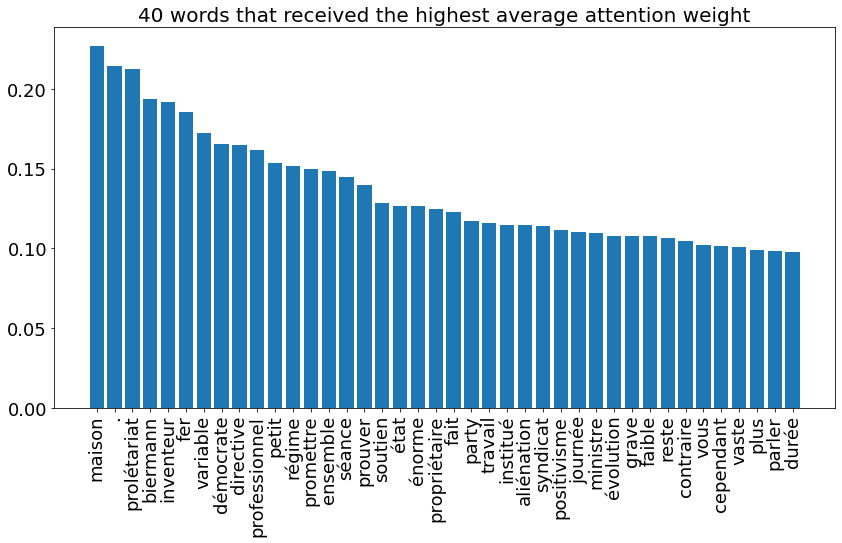

In [20]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (14,7)

N_WORDS = 40
x = list(avg_attention_mass.keys())[:N_WORDS]
y = list(avg_attention_mass.values())[:N_WORDS]
plt.bar(x, y)
plt.xticks(rotation=90, fontsize=18)
plt.yticks(fontsize=18)
plt.title(f'{N_WORDS} words that received the highest average attention weight', fontsize=20)

fig_path = path.join(tmp_path, 'figures')
os.makedirs(fig_path, exist_ok=True)
plt.savefig(path.join(fig_path, f'v2.png'),dpi=100)
plt.show()

# Evaluation in a subset

# Evaluation in pre-established links

## QA Links

In [ ]:
for side, frequency in attended_word_frequency.items():
    sorted_frequency = dict(sorted(frequency.items(), key=lambda x: x[1], reverse=True))
    attended_word_frequency[side] = sorted_frequency

## Similarity Links

## TF-IDF

In [119]:
n = 20

for side, frequency in attended_word_frequency.items():
    print(str(n)+' words most attended in '+ side)
    print()
    top_n = dict(list(frequency.items())[:n])
    df = pd.DataFrame(list(frequency.items()), columns=['Word', 'Count'])
    df = df[df['Count'] > 1]
    display(df.transpose())
    print('=20')

20 words most attended in premise



,0,1,2,3,4,5,6,7,8,9,...,2684,2685,2686,2687,2688,2689,2690,2691,2692,2693
Word,le,de,",",.,être,et,un,ce,à,que,...,participant,dépense,sortie,1957,varga,épisode,phénomène,pourvoir,franc,octroyer
Count,5562,4936,2366,1300,1016,976,970,786,766,624,...,2,2,2,2,2,2,2,2,2,2


=20
20 words most attended in hypothesis



,0,1,2,3,4,5,6,7,8,9,...,4267,4268,4269,4270,4271,4272,4273,4274,4275,4276
Word,le,de,",",.,et,un,être,à,que,ce,...,archive,prôner,workers,motor,copropriétaire,1851,dépourvu,p.a.l.,s.e.c.a.m.,popularité
Count,10767,9707,6117,2902,2515,2509,2314,2087,1612,1427,...,2,2,2,2,2,2,2,2,2,2


=20


In [124]:
for side, frequency in attended_word_frequency.items():
    top_n = dict(list(frequency.items())[:n])
    df = pd.DataFrame(list(frequency.items()), columns=['Word', 'Count'])
    df = df[df['Count'] > 1]
    display(df[50:].transpose())
    print('=20')

,50,51,52,53,54,55,56,57,58,59,...,2684,2685,2686,2687,2688,2689,2690,2691,2692,2693
Word,conseil,travailleur,entreprise,entre,politique,si,société,révolution,celui,autre,...,participant,dépense,sortie,1957,varga,épisode,phénomène,pourvoir,franc,octroyer
Count,106,104,103,101,100,98,96,93,92,90,...,2,2,2,2,2,2,2,2,2,2


=20


,50,51,52,53,54,55,56,57,58,59,...,4267,4268,4269,4270,4271,4272,4273,4274,4275,4276
Word,avec,conseil,devoir,société,entreprise,travailleur,politique,dire,celui,économique,...,archive,prôner,workers,motor,copropriétaire,1851,dépourvu,p.a.l.,s.e.c.a.m.,popularité
Count,228,225,224,220,219,212,208,203,200,188,...,2,2,2,2,2,2,2,2,2,2


=20


In [ ]:
for side, frequency in attended_word_frequency.items():
    top_n = dict(list(frequency.items())[:n])
    df = pd.DataFrame(list(frequency.items()), columns=['Word', 'Count'])
    df = df[df['Count'] > 1]
    display(df[50:].transpose())
    print('=20')

#### Test on Archival study subset : on work



In [22]:
## Server parameters
ON_IGRIDA = True

if ON_IGRIDA:
    SERVER_DIR = '/srv/tempdd/dunguyen/RUNS'
else:
    SERVER_DIR = '/Users/dunguyen/Projects/IGRIDA/historic/2023-02-23/archival'

LOG_PATH = path.join(SERVER_DIR, 'logs')
DATA_CACHE = path.join(SERVER_DIR, 'dataset')
#MODEL_CACHE = path.join(SERVER_DIR, 'models')

## Model parameters (the model inference has already been done in IGRIDA. In this notebook we retrieve only its inference)
MODEL_NAME = 'run=6_vector=0_lentropy=0.05'

In [25]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

POST_PROCESS_INFERENCE_PATH = path.join(LOG_PATH, 'archival', MODEL_NAME, 'predictions','clean_inference_sentence_pairs_v2.json')
INFERENCE_PATH = path.join(LOG_PATH, 'archival', MODEL_NAME, 'predictions','batch_inference_sentence_pairs_v2.json')

# load inference file
if path.exists(POST_PROCESS_INFERENCE_PATH):
    inference_sentences = pd.read_json(POST_PROCESS_INFERENCE_PATH, encoding='utf-8')
    print(f'Load inference_sentences from {POST_PROCESS_INFERENCE_PATH}')
else:
    
    inference_sentences = pd.read_json(INFERENCE_PATH, orient='records', encoding='utf-8')

    def remove_mask(row):
        for side in ['premise', 'hypothesis']:
            padding_mask = np.array(row[f'padding_mask.{side}'])

            a_hat = np.array(row[f'a_hat.{side}'])
            a_hat = a_hat[~padding_mask]
            row[f'a_hat.{side}'] = a_hat.tolist()

            ids = np.array(row[f'{side}_ids'])
            ids = ids[~padding_mask]
            row[f'{side}_ids'] = ids.tolist()
        return row

    if 'padding_mask.premise' in inference_sentences.columns:
        tqdm.pandas(desc='remove_mask')
        inference_sentences = inference_sentences.progress_apply(remove_mask,axis=1)
        inference_sentences.drop(columns=['padding_mask.premise', 'padding_mask.hypothesis'], inplace=True)
    
    with open(POST_PROCESS_INFERENCE_PATH, 'w', encoding='utf-8') as f:
        inference_sentences.to_json(f, force_ascii=False)
        print(f'Save inference_sentences to {POST_PROCESS_INFERENCE_PATH}')
        
inference_sentences

remove_mask:   0%|          | 0/223666 [00:00<?, ?it/s]

Save inference_sentences to /srv/tempdd/dunguyen/RUNS/logs/archival/run=6_vector=0_lentropy=0.05/predictions/clean_inference_sentence_pairs_v2.json


,y_hat,y_score,a_hat.premise,a_hat.hypothesis,source.bloc.id,target.bloc.id,source.sentence.id,target.sentence.id,source.bloc.uid,target.bloc.uid,...,hypothesis_ids,source.bloc.index,target.bloc.index,source.sentence.index,target.sentence.index,source.tokens,target.tokens,source.article.title,premise.tokens,hypothesis.tokens
0,1,0.816464,"[0.007651310400000001, 0.013778822500000001, 0...","[0.0627513155, 0.0203241948, 0.0320522711, 0.0...",80.0,35.0,0.0,2.0,FMSH_PB188a_18-19_201_07,FMSH_PB188a_11-12_125_02,...,"[12624, 12632, 11727, 12637, 11508, 12630, 126...",NaN,NaN,NaN,NaN,None,None,None,None,None
1,0,0.382935,"[0.0495468192, 0.0609955639, 0.0146217896, 0.0...","[0.028592417000000002, 0.022165052600000002, 0...",80.0,35.0,1.0,0.0,FMSH_PB188a_18-19_201_07,FMSH_PB188a_11-12_125_02,...,"[12638, 11707, 12446, 11577, 11482, 12638, 124...",NaN,NaN,NaN,NaN,None,None,None,None,None
2,1,0.767685,"[0.0353953615, 0.034988597, 0.01225645, 0.0257...","[0.0183737185, 0.0168948267, 0.0108001148, 0.0...",80.0,35.0,1.0,1.0,FMSH_PB188a_18-19_201_07,FMSH_PB188a_11-12_125_02,...,"[12629, 12446, 12632, 12518, 11202, 12631, 879...",NaN,NaN,NaN,NaN,None,None,None,None,None
3,1,0.736607,"[0.0379820652, 0.033533476300000004, 0.0103123...","[0.0449870862, 0.0260418579, 0.0365362316, 0.0...",80.0,35.0,1.0,2.0,FMSH_PB188a_18-19_201_07,FMSH_PB188a_11-12_125_02,...,"[12624, 12632, 11727, 12637, 11508, 12630, 126...",NaN,NaN,NaN,NaN,None,None,None,None,None
4,0,0.009523,"[0.5871393681, 0.4128606319]","[0.0293221492, 0.0265875515, 0.0202338286, 0.0...",80.0,35.0,2.0,0.0,FMSH_PB188a_18-19_201_07,FMSH_PB188a_11-12_125_02,...,"[12638, 11707, 12446, 11577, 11482, 12638, 124...",NaN,NaN,NaN,NaN,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223661,1,0.990256,"[0.09885212780000001, 0.059863925000000005, 0....","[0.0161787346, 0.0162396468, 0.0161599331, 0.0...",137.0,142.0,2.0,1.0,FMSH_PB188a_20-21_064_02,FMSH_PB188a_20-21_067_02,...,"[12638, 11638, 12637, 12629, 12487, 12328, 113...",NaN,NaN,NaN,NaN,None,None,None,None,None
223662,1,0.960653,"[0.0758343861, 0.0483686328, 0.1165912524, 0.4...","[0.0896834284, 0.0997016653, 0.1304979771, 0.0...",137.0,142.0,2.0,2.0,FMSH_PB188a_20-21_064_02,FMSH_PB188a_20-21_067_02,...,"[12638, 1563, 10637, 12619, 1, 12611, 12423, 1...",NaN,NaN,NaN,NaN,None,None,None,None,None
223663,0,0.029427,"[0.0108872922, 0.0054137427, 0.0020751467, 0.0...","[0.0018269485, 0.0016038899000000001, 0.003085...",137.0,143.0,0.0,0.0,FMSH_PB188a_20-21_064_02,FMSH_PB188a_20-21_069_03,...,"[12625, 12613, 6217, 12592, 12606, 12459, 1262...",NaN,NaN,NaN,NaN,None,None,None,None,None
223664,1,0.501854,"[0.0066407137, 0.0056945598, 0.0025590872, 0.0...","[0.3468779922, 0.17439484600000002, 0.11852170...",137.0,143.0,0.0,1.0,FMSH_PB188a_20-21_064_02,FMSH_PB188a_20-21_069_03,...,"[12626, 12621, 12370, 12623, 12635]",NaN,NaN,NaN,NaN,None,None,None,None,None
